# Assignment 3: Classical Hough Transform

## Ex. 3.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

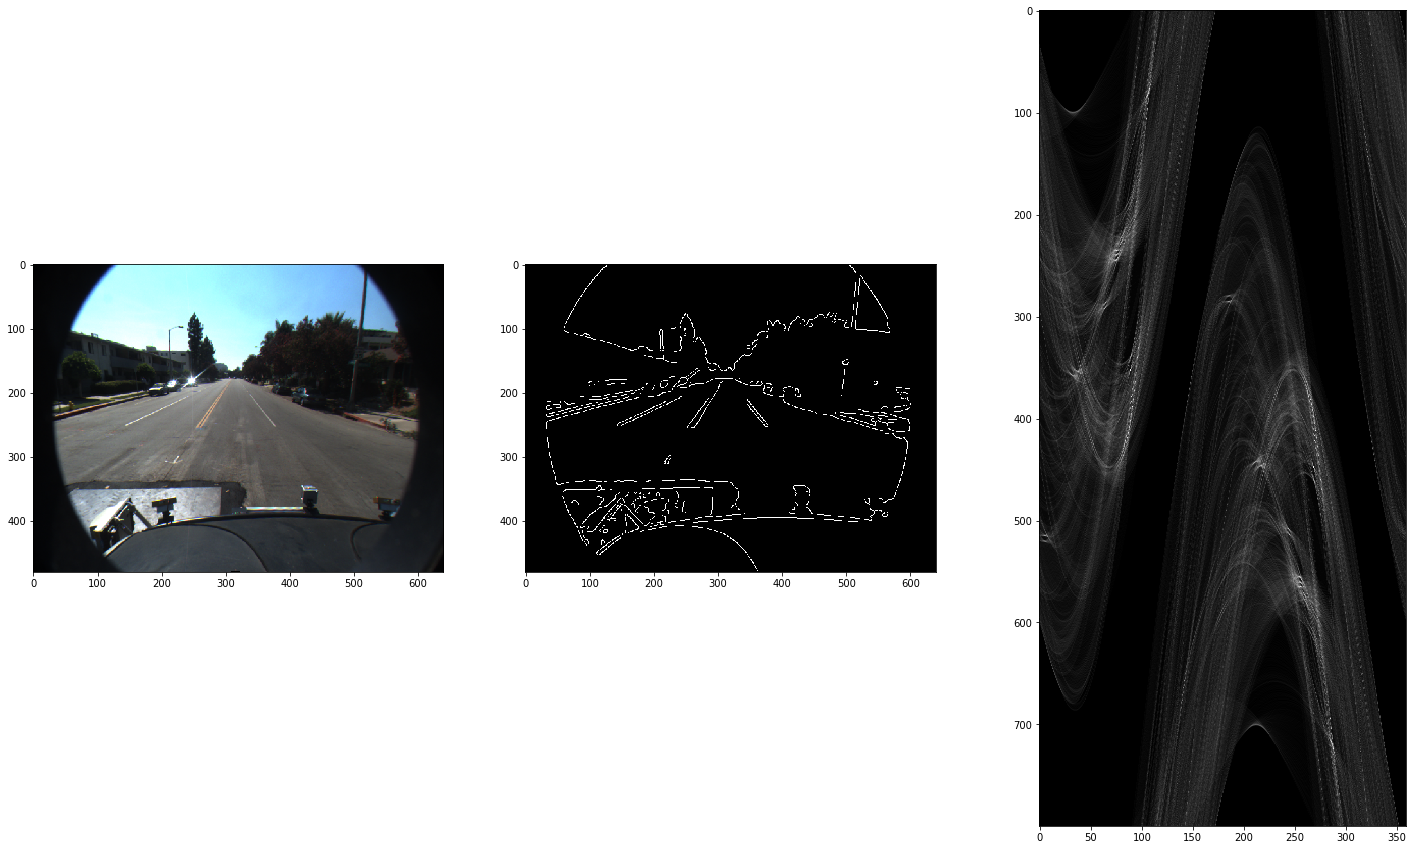

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
import math

def hough_accumulator(image):
    image_height, image_width = image.shape
    image_diagonal = int(round(math.sqrt(math.pow(image_width, 2) + math.pow(image_height, 2))))
    accumulator = np.zeros((image_diagonal, 360), dtype=int)
    for (y, x), is_edge in np.ndenumerate(image):
        if is_edge:
            for a in range(360):
                r = int(round(x * math.cos(math.radians(a)) + y * math.sin(math.radians(a))))
                accumulator[r, a] += 1

    return accumulator
    

image = io.imread('images/lane_detection/f00000.png')
edge_image = feature.canny(color.rgb2gray(image), 2)
accumulator = hough_accumulator(edge_image)

fig = plt.figure(figsize=(25, 15))

ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image)
ax2.imshow(edge_image, cmap=plt.cm.gray)
ax3.imshow(accumulator, cmap=plt.cm.gray)

In [7]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt und von Tim renoviert

from skimage.draw import line

def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0*math.cos(math.radians(a)))/math.sin(math.radians(a)))
    x1 = dimx
    y1 = round((r - x1*math.cos(math.radians(a)))/math.sin(math.radians(a)))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret


## line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

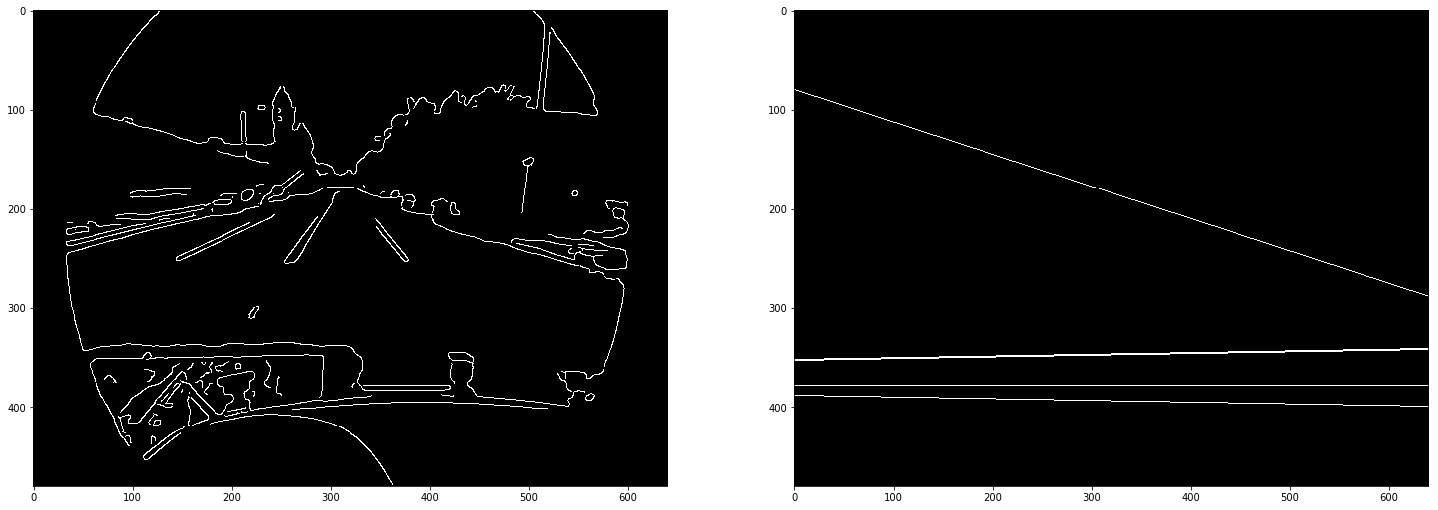

In [9]:
edge_count = 10

maxima = np.zeros((edge_count, 3))

for r in range(len(accumulator)):
    for a in range(len(accumulator[0])):
        pos = 0
        for m in range(edge_count):
            if accumulator[r, a] >= maxima[m, 0]:
                pos += 1
                if pos == edge_count:
                    maxima = np.insert(maxima, pos, [accumulator[r, a], r, a], axis=0)[1:]
            else:
                maxima = np.insert(maxima, pos, [accumulator[r, a], r, a], axis=0)[1:]
                break

edge_image_new = np.zeros(edge_image.shape)#edge_image.copy()#
for m in maxima:
    edge_image_new = draw_line_hessian_normal(edge_image_new, int(m[2]), int(m[1]))

fig = plt.figure(figsize=(25, 15))    

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(edge_image, cmap=plt.cm.gray)
ax2.imshow(edge_image_new, cmap=plt.cm.gray)

## circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

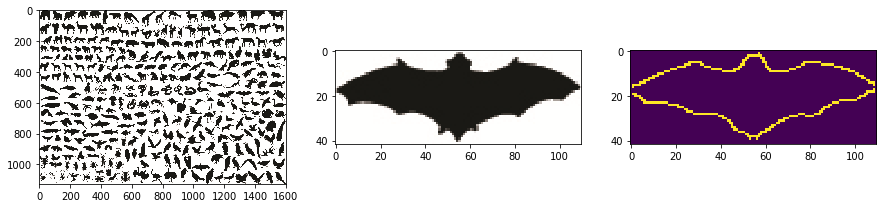

In [104]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_edge = feature.canny(color.rgb2gray(bat), 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)

In [105]:
def create_r_table(image, image_edge):
    image = color.rgb2gray(image)

    height, width = image.shape
    center_x = int(width/2)
    center_y = int(height/2)

    y_gradient, x_gradient = np.gradient(image)
    gradients = np.degrees(np.arctan2(y_gradient, x_gradient))

    r_table = {}
    for y in range(height):
        for x in range(width):
            if image_edge[y, x]:
                gradient = int(round(gradients[y, x], 0))
                if gradient in r_table:
                    r_table[gradient] += [(center_x - x, center_y - y)]
                else:
                    r_table[gradient] = [(center_x - x, center_y - y)]

    return r_table

r_table = create_r_table(bat, bat_edge)

In [106]:
def generalized_hough_transform(image, r_table):
    image = color.rgb2gray(image)
    image_canny = feature.canny(image)
    
    y_gradient, x_gradient = np.gradient(image)
    image_sobel = np.degrees(np.arctan2(y_gradient, x_gradient))
    
    height, width = image.shape

    accumulator = np.zeros((height,width))
    for y in range(height):
        for x in range(width):
            if image_canny[y, x]:
                gradient = int(round(image_sobel[y, x], 0))
                if gradient in r_table:
                    for (vector_x, vector_y) in r_table[gradient]:
                        if (vector_y + y >= 0 and
                            vector_x + x >= 0 and
                            vector_y + y < height and
                            vector_x + x < width):
                            accumulator[y + vector_y, x + vector_x] += 1

    return accumulator

accumulator = generalized_hough_transform(animals, r_table)

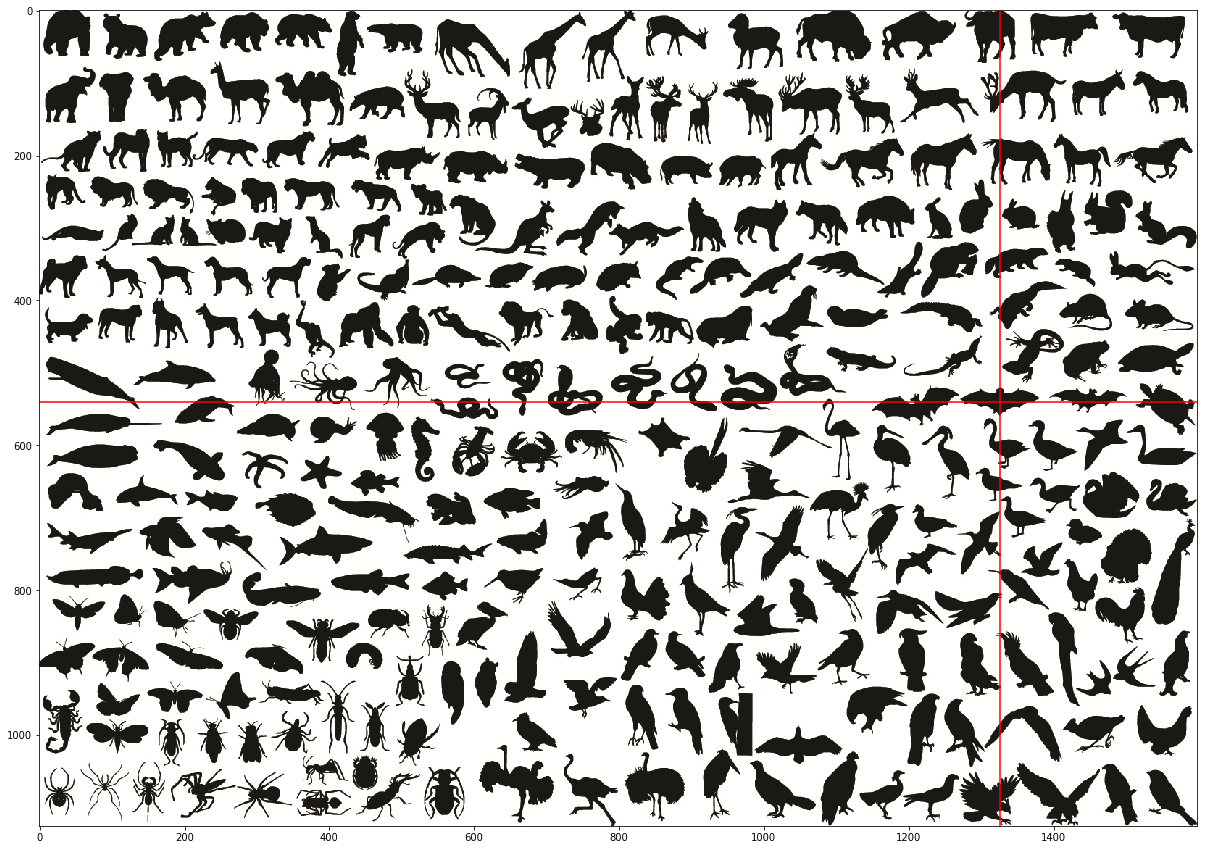

In [108]:
fig = plt.figure(figsize=(25, 15))
ax1 = plt.subplot(1, 1, 1)

y, x = np.unravel_index(accumulator.argmax(), accumulator.shape)
ax1.axvline(x, color='red')
ax1.axhline(y, color='red')

ax1.imshow(animals)

* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)